In [33]:
%matplotlib inline

In [34]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vtk_rw import read_vtk
import lmfit
import pandas as pd

In [35]:
colors = sns.color_palette('cubehelix', 10)

### Load data

In [36]:
hemi='rh'

mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d.vtk'%hemi
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d_sulc.npy'%hemi
mask_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/%s_fullmask.npy'%hemi
embed_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/connectivity/%s_smooth_3_embed_10.npy'%hemi
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/smooth_3/avg_%s_profiles_smooth_3.npy'%hemi
r1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/smooth_3/avg_%s_r1_smooth_3.npy'%hemi

In [37]:
v,f,d = read_vtk(mesh_file)
mask = np.load(mask_file)
embedding = np.load(embed_file)
t1_profiles = np.load(t1_file)
r1_profiles = np.load(r1_file)
sulc = np.load(sulc_file)

### Mask and average

In [38]:
t1_profiles[mask]=0
r1_profiles[mask]=0

In [39]:
t1_avg = np.mean(t1_profiles[:,3:8], axis=1)
r1_avg = np.mean(r1_profiles[:,3:8], axis=1)

In [40]:
scatter_t1avg = np.delete(t1_avg, mask)
scatter_r1avg = np.delete(r1_avg, mask)

scatter_embed_t1 = np.delete(embedding, mask, axis=0)
scatter_embed_r1 = np.delete(embedding, mask, axis=0)

t1_idx=np.where(scatter_t1avg<=1500)
scatter_t1avg = np.delete(scatter_t1avg, t1_idx)
scatter_embed_t1 = np.delete(scatter_embed_t1, t1_idx, axis=0)

r1_idx=np.where(scatter_r1avg>(1./1500))
scatter_r1avg = np.delete(scatter_r1avg, r1_idx)
scatter_embed_r1 = np.delete(scatter_embed_r1, r1_idx, axis=0)

### Plot 2D histogramms

In [41]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.3)

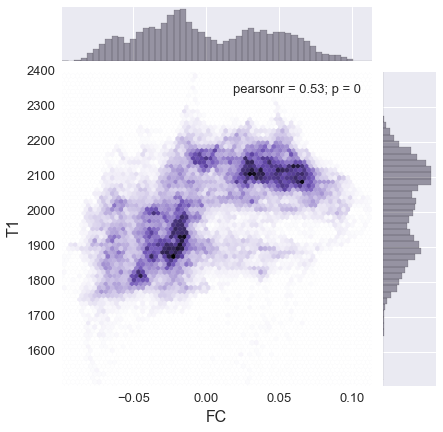

In [42]:
g = sns.jointplot(scatter_embed_t1[:,0], scatter_t1avg, kind="hex", size=6, color=colors[0])
g.set_axis_labels('FC', 'T1', fontsize=16)

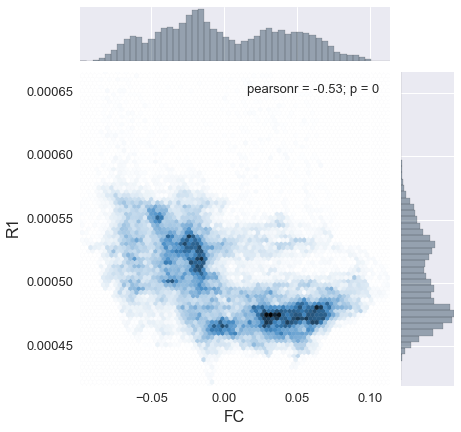

In [43]:
g = sns.jointplot(scatter_embed_r1[:,0], scatter_r1avg, kind="hex", size=6, color=colors[1])
g.set_axis_labels('FC', 'R1', fontsize=16)

### Normalize data to get sensible model comparison

"Note that the calculation of chi-square and reduced chi-square assume that the returned residual function is scaled properly to the uncertainties in the data. For these statistics to be meaningful, the person writing the function to be minimized must scale them properly."

Is this valid, given the data are not normally distributed? 

In [44]:
t1_norm = (scatter_t1avg - np.mean(scatter_t1avg))# / (np.std(scatter_t1avg))
r1_norm = (scatter_r1avg - np.mean(scatter_r1avg))# / (np.std(scatter_r1avg))
embed1_t1_norm = (scatter_embed_t1[:,0] - np.mean(scatter_embed_t1[:,0]))# / (np.std(scatter_embed_t1[:,0]))
embed1_r1_norm = (scatter_embed_r1[:,0] - np.mean(scatter_embed_r1[:,0]))# / (np.std(scatter_embed_r1[:,0]))

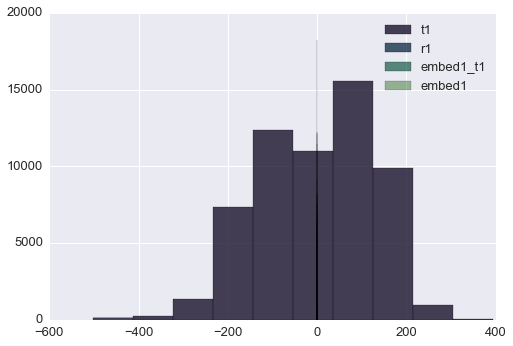

In [46]:
plt.hist(t1_norm, alpha=0.8, color=colors[0], label='t1');
plt.hist(r1_norm, alpha=0.8, color=colors[1], label='r1');
#plt.hist(embed1_t1_norm, alpha=0.7, color=colors[2], label='embed1_t1');
plt.hist(embed1_r1_norm, alpha=0.5, color=colors[3], label='embed1');
plt.legend()

### Model

In [14]:
def custom_plot(x, y, res, xlabel=None, ylabel=None, data_color=colors[1]):
    fig=plt.figure(figsize=(12,5))
    fig.add_subplot(121)
    plt.plot(x, y, alpha=0.1, marker='.', linestyle='None', color=data_color)
    plt.plot(x, res.best_fit, color='black', linestyle='None', marker='.', markersize=.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.add_subplot(122)
    res.plot_residuals(data_kws={'alpha':0.1, 'color':'grey', 'marker':'.'}, fit_kws={'color':'k', 'linewidth':2})
    
def custom_report(res, label):
    print '##### %s #####'%label
    print res.fit_report()
    print 'BIC', res.bic
    print 'AIC', res.aic
    print ''

In [15]:
def fit_simple(model, x, y, t1type, xlabel, ylabel, color):
    
    pars = model.guess(y, x=x)
    out = model.fit(y, pars, x=x)
    
    custom_report(out, t1type)
    custom_plot(x,y, out, xlabel=xlabel, ylabel=ylabel, data_color=color)
    
    return out

In [16]:
def fit_composite_const(model, x, y, t1type, xlabel, ylabel, color):
    
    const_model = lmfit.models.LinearModel(prefix='const_')
    const_model.set_param_hint(name='slope', value=0, vary=False)
    comp_model = model + const_model
    
    pars = const_model.make_params(intercept=y.min())
    pars += model.guess(y, x=x)
    out = comp_model.fit(y, pars, x=x)
    
    custom_report(out, t1type)
    custom_plot(x,y, out, xlabel=xlabel, ylabel=ylabel, data_color=color)
    
    return out

### Linear fit

##### T1avg #####
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 58921
    # variables        = 2
    chi-square         = 42125.002
    reduced chi-square = 0.715
[[Variables]]
    slope:       0.53390974 +/- 0        (0.00%) (init= 0.5339097)
    intercept:   4.8482e-16 +/- 0        (0.00%) (init= 4.848206e-16)
[[Correlations]] (unreported correlations are <  0.100)

BIC -19747.334311
AIC -19765.3022166

##### R1avg #####
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 58818
    # variables        = 2
    chi-square         = 42332.394
    reduced chi-square = 0.720
[[Variables]]
    slope:      -0.52941633 +/- 0        (0.00%) (init=-0.5294163)
    intercept:  -3.1580e-15 +/- 0        (0.00%) (init=-3.157983e-15)
[[Correlations]] (unreported correlations are <  0.100)

BIC -19321.0011153
AIC -19338.9655217



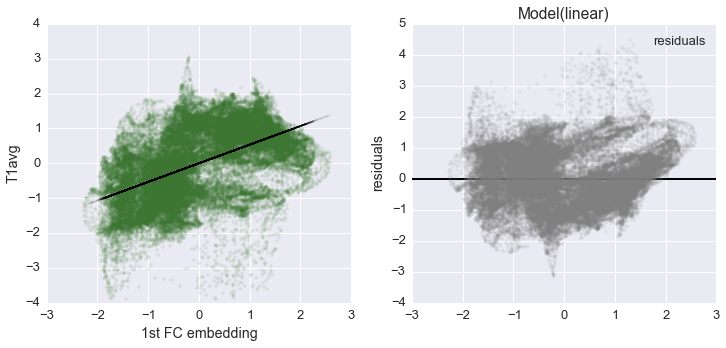

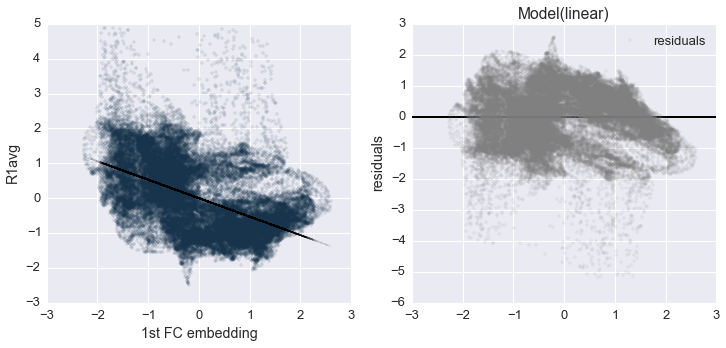

In [17]:
lin_mod = lmfit.models.LinearModel()

lin_t1 = fit_simple(lin_mod, 
                        x=embed1_t1_norm, y=t1_norm,
                        t1type='T1avg',
                        xlabel='1st FC embedding',
                        ylabel='T1avg', 
                        color=colors[3])


lin_r1 = fit_simple(lin_mod,
                        x=embed1_r1_norm, y=r1_norm,
                        t1type='R1avg',
                        xlabel='1st FC embedding',
                        ylabel='R1avg', 
                        color=colors[1])

### Quadratic fit

##### T1avg #####
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 58921
    # variables        = 3
    chi-square         = 40405.342
    reduced chi-square = 0.686
[[Variables]]
    a:  -0.16914508 +/- 0.003377 (2.00%) (init=-0.1691451)
    b:   0.56125768 +/- 0.003455 (0.62%) (init= 0.5612577)
    c:   0.16914508 +/- 0.004800 (2.84%) (init= 0.1691451)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, c)                      = -0.704 
    C(a, b)                      = -0.158 
    C(b, c)                      =  0.111 

BIC -22191.1448012
AIC -22218.0966597

##### R1avg #####
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 58818
    # variables        = 3
    chi-square         = 40689.162
    reduced chi-square = 0.692
[[Variables]]
    a:   0.16554452 +/- 0.003396 (2.05%) (init= 0.1655445)
    b:  -0.55643395 +/- 0.003474 (0.62%) (init=-0.556434)
    c:  -0.1655

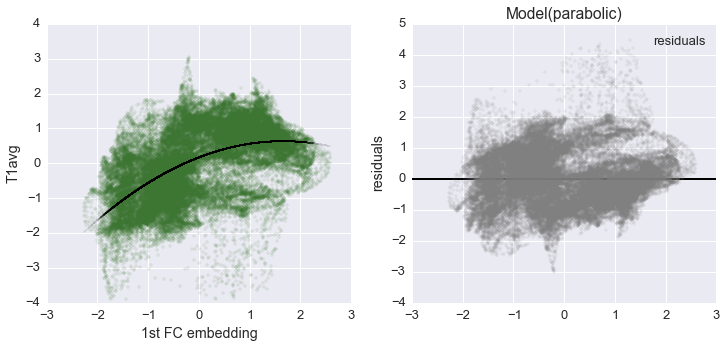

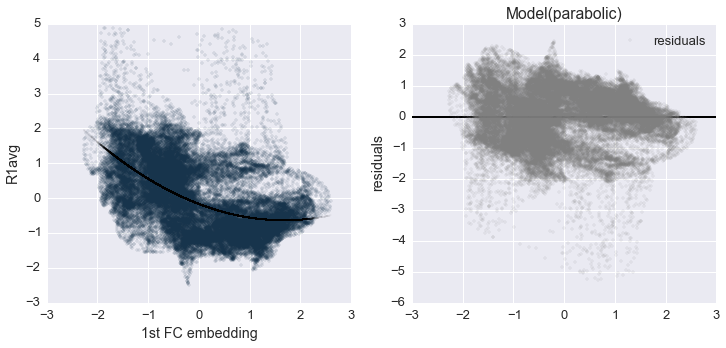

In [18]:
quad_mod = lmfit.models.QuadraticModel()

quad_t1 = fit_simple(quad_mod, 
                        x=embed1_t1_norm, y=t1_norm,
                        t1type='T1avg',
                        xlabel='1st FC embedding',
                        ylabel='T1avg', 
                        color=colors[3])


quad_r1 = fit_simple(quad_mod, 
                        x=embed1_r1_norm, y=r1_norm,
                        t1type='R1avg',
                        xlabel='1st FC embedding',
                        ylabel='R1avg', 
                        color=colors[1])

### Polynomial model degree=3

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 7
    # data points      = 58921
    # variables        = 4
    chi-square         = 39173.474
    reduced chi-square = 0.665
[[Variables]]
    c0:   0.16085779 +/- 0.004731 (2.94%) (init= 0.1608578)
    c1:   0.81309582 +/- 0.006767 (0.83%) (init= 0.8130958)
    c2:  -0.14059437 +/- 0.003391 (2.41%) (init=-0.1405944)
    c3:  -0.12532785 +/- 0.002911 (2.32%) (init=-0.1253279)
[[Correlations]] (unreported correlations are <  0.100)
    C(c1, c3)                    = -0.864 
    C(c0, c2)                    = -0.697 
    C(c2, c3)                    = -0.196 

BIC -24003.4829648
AIC -24039.4187762

##### R1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 7
    # data points      = 58818
    # variables        = 4
    chi-square         = 39669.902
    reduced chi-square = 0.674
[[Variables]]
    c0:  -0.15799829 +/- 0.004770 (3.02%) (init=-0.1579983)
    c1:

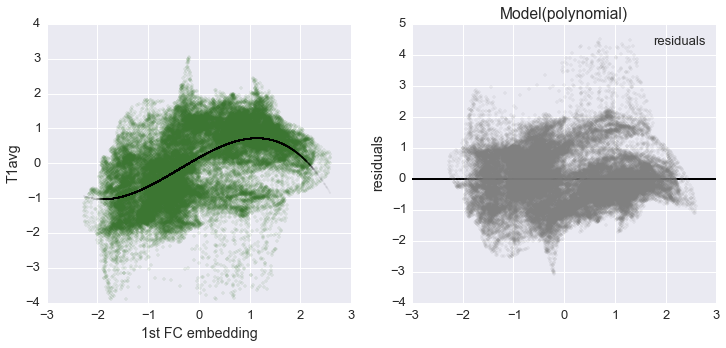

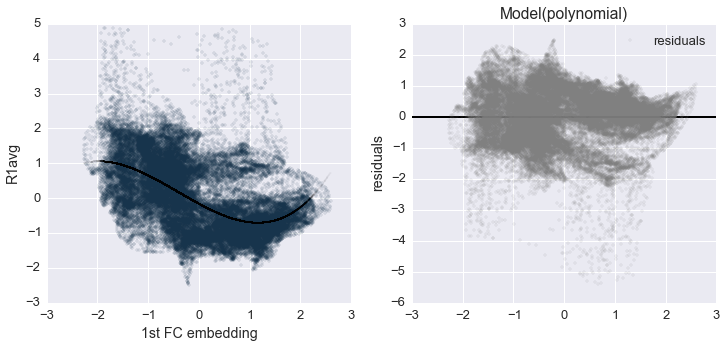

In [19]:
poly3_mod = lmfit.models.PolynomialModel(degree=3)

poly3_t1 = fit_simple(poly3_mod, 
                        x=embed1_t1_norm, y=t1_norm,
                        t1type='T1avg',
                        xlabel='1st FC embedding',
                        ylabel='T1avg', 
                        color=colors[3])


poly3_r1 = fit_simple(poly3_mod, 
                        x=embed1_r1_norm, y=r1_norm,
                        t1type='R1avg',
                        xlabel='1st FC embedding',
                        ylabel='R1avg', 
                        color=colors[1])

### Polynomial fit degree=4

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 8
    # data points      = 58921
    # variables        = 5
    chi-square         = 39113.269
    reduced chi-square = 0.664
[[Variables]]
    c0:   0.19265402 +/- 0.005787 (3.00%) (init= 0.192654)
    c1:   0.83610399 +/- 0.007181 (0.86%) (init= 0.836104)
    c2:  -0.22087689 +/- 0.009086 (4.11%) (init=-0.2208769)
    c3:  -0.13900560 +/- 0.003244 (2.33%) (init=-0.1390056)
    c4:   0.02477572 +/- 0.002601 (10.50%) (init= 0.02477572)
[[Correlations]] (unreported correlations are <  0.100)
    C(c2, c4)                    = -0.928 
    C(c1, c3)                    = -0.879 
    C(c0, c2)                    = -0.748 
    C(c0, c4)                    =  0.577 
    C(c3, c4)                    = -0.443 
    C(c2, c3)                    =  0.345 
    C(c1, c4)                    =  0.336 
    C(c1, c2)                    = -0.280 
    C(c0, c3)                    = -0.226 
    C(c0, c1)          

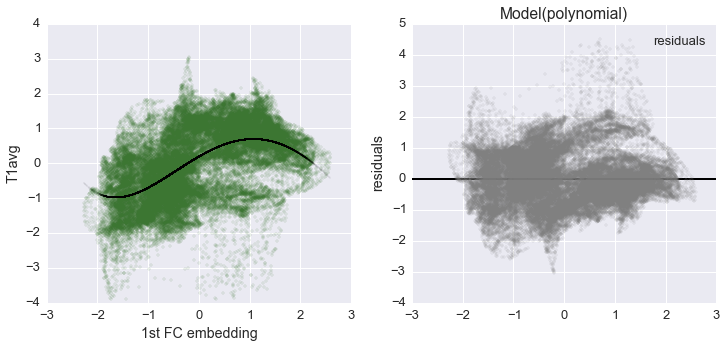

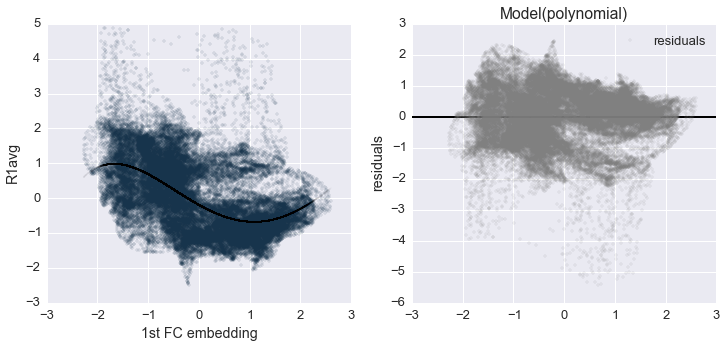

In [20]:
poly4_mod = lmfit.models.PolynomialModel(degree=4)

poly4_t1 = fit_simple(poly4_mod, 
                        x=embed1_t1_norm, y=t1_norm,
                        t1type='T1avg',
                        xlabel='1st FC embedding',
                        ylabel='T1avg', 
                        color=colors[3])


poly4_r1 = fit_simple(poly4_mod, 
                        x=embed1_r1_norm, y=r1_norm,
                        t1type='R1avg',
                        xlabel='1st FC embedding',
                        ylabel='R1avg', 
                        color=colors[1])

### Polynomial fit degree=5

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 58921
    # variables        = 6
    chi-square         = 38986.399
    reduced chi-square = 0.662
[[Variables]]
    c0:   0.18466545 +/- 0.005807 (3.14%) (init= 0.1846655)
    c1:   0.94168339 +/- 0.010466 (1.11%) (init= 0.9416834)
    c2:  -0.17169048 +/- 0.009742 (5.67%) (init=-0.1716905)
    c3:  -0.26628895 +/- 0.009746 (3.66%) (init=-0.266289)
    c4:   0.00446892 +/- 0.002982 (66.75%) (init= 0.004468929)
    c5:   0.02887874 +/- 0.002085 (7.22%) (init= 0.02887874)
[[Correlations]] (unreported correlations are <  0.100)
    C(c3, c5)                    = -0.943 
    C(c2, c4)                    = -0.932 
    C(c1, c3)                    = -0.887 
    C(c0, c2)                    = -0.729 
    C(c1, c5)                    =  0.729 
    C(c0, c4)                    =  0.549 
    C(c4, c5)                    = -0.492 
    C(c2, c5)                    =  0.365 
   

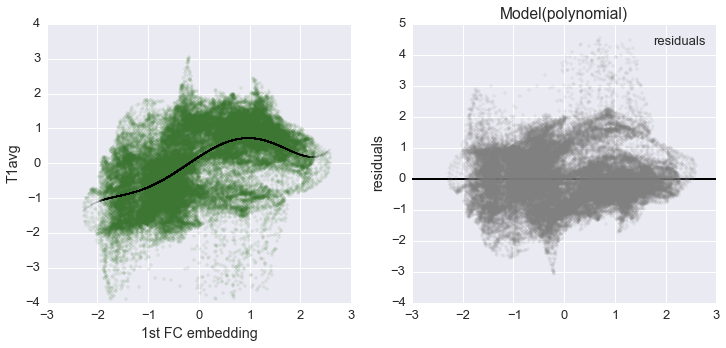

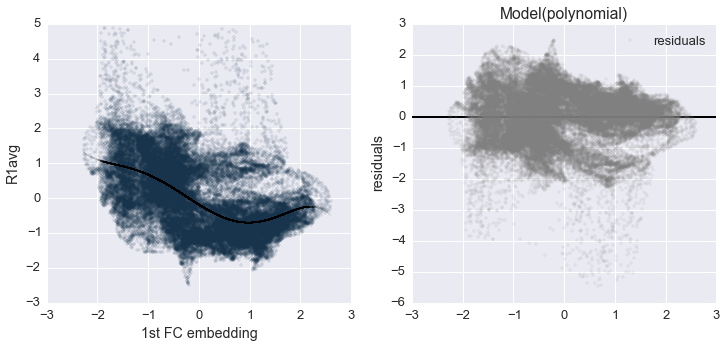

In [21]:
poly5_mod = lmfit.models.PolynomialModel(degree=5)

poly5_t1 = fit_simple(poly5_mod, 
                        x=embed1_t1_norm, y=t1_norm,
                        t1type='T1avg',
                        xlabel='1st FC embedding',
                        ylabel='T1avg', 
                        color=colors[3])


poly5_r1 = fit_simple(poly5_mod, 
                        x=embed1_r1_norm, y=r1_norm,
                        t1type='R1avg',
                        xlabel='1st FC embedding',
                        ylabel='R1avg', 
                        color=colors[1])

### Polynomial fit degree=6

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 10
    # data points      = 58921
    # variables        = 7
    chi-square         = 38872.081
    reduced chi-square = 0.660
[[Variables]]
    c0:   0.22851219 +/- 0.006687 (2.93%) (init= 0.2285122)
    c1:   0.99282920 +/- 0.011150 (1.12%) (init= 0.9928292)
    c2:  -0.36123068 +/- 0.017377 (4.81%) (init=-0.3612307)
    c3:  -0.33896364 +/- 0.011189 (3.30%) (init=-0.3389636)
    c4:   0.13614694 +/- 0.010437 (7.67%) (init= 0.1361469)
    c5:   0.04812334 +/- 0.002544 (5.29%) (init= 0.04812335)
    c6:  -0.02250268 +/- 0.001709 (7.60%) (init=-0.02250268)
[[Correlations]] (unreported correlations are <  0.100)
    C(c4, c6)                    = -0.958 
    C(c3, c5)                    = -0.955 
    C(c2, c4)                    = -0.943 
    C(c1, c3)                    = -0.895 
    C(c2, c6)                    =  0.829 
    C(c0, c2)                    = -0.767 
    C(c1, c5)                

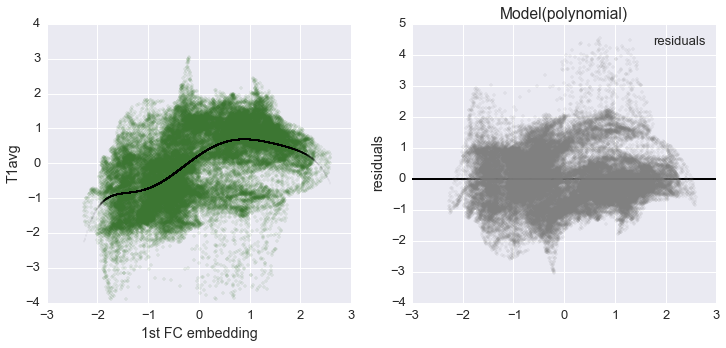

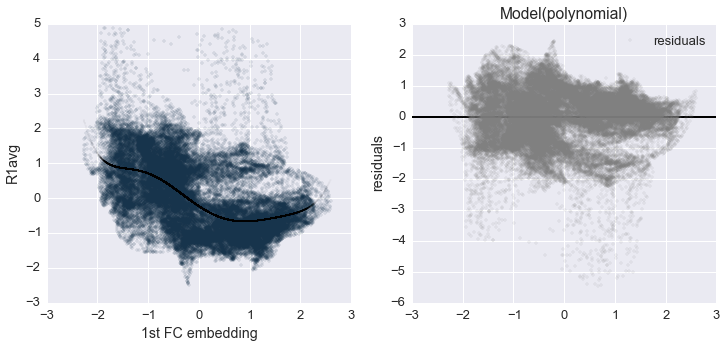

In [22]:
poly6_mod = lmfit.models.PolynomialModel(degree=6)

poly6_t1 = fit_simple(poly6_mod, 
                        x=embed1_t1_norm, y=t1_norm,
                        t1type='T1avg',
                        xlabel='1st FC embedding',
                        ylabel='T1avg', 
                        color=colors[3])


poly6_r1 = fit_simple(poly6_mod, 
                        x=embed1_r1_norm, y=r1_norm,
                        t1type='R1avg',
                        xlabel='1st FC embedding',
                        ylabel='R1avg', 
                        color=colors[1])

### Polynomial fit degree=7

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 11
    # data points      = 58921
    # variables        = 8
    chi-square         = 38868.234
    reduced chi-square = 0.660
[[Variables]]
    c0:   0.23082200 +/- 0.006755 (2.93%) (init= 0.230822)
    c1:   0.97055105 +/- 0.014471 (1.49%) (init= 0.9705511)
    c2:  -0.38083792 +/- 0.019180 (5.04%) (init=-0.3808379)
    c3:  -0.29304285 +/- 0.022063 (7.53%) (init=-0.2930429)
    c4:   0.15275179 +/- 0.012498 (8.18%) (init= 0.1527518)
    c5:   0.02523653 +/- 0.009813 (38.88%) (init= 0.02523653)
    c6:  -0.02573772 +/- 0.002171 (8.44%) (init=-0.02573772)
    c7:   0.00318001 +/- 0.001316 (41.41%) (init= 0.003180018)
[[Correlations]] (unreported correlations are <  0.100)
    C(c4, c6)                    = -0.969 
    C(c5, c7)                    = -0.966 
    C(c3, c5)                    = -0.958 
    C(c2, c4)                    = -0.946 
    C(c1, c3)                    = -0.899 
    C(c3,

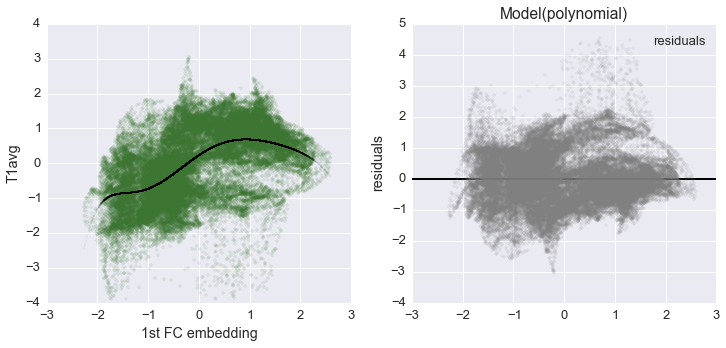

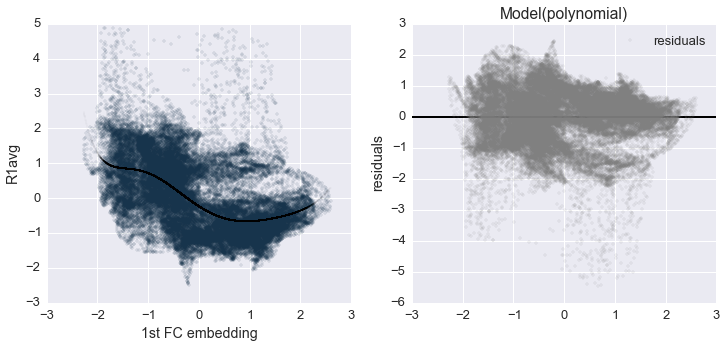

In [23]:
poly7_mod = lmfit.models.PolynomialModel(degree=7)

poly7_t1 = fit_simple(poly7_mod, 
                        x=embed1_t1_norm, y=t1_norm,
                        t1type='T1avg',
                        xlabel='1st FC embedding',
                        ylabel='T1avg', 
                        color=colors[3])


poly7_r1 = fit_simple(poly7_mod, 
                        x=embed1_r1_norm, y=r1_norm,
                        t1type='R1avg',
                        xlabel='1st FC embedding',
                        ylabel='R1avg', 
                        color=colors[1])

### Linear step function

##### T1avg #####
[[Model]]
    Model(step, form='linear')
[[Fit Statistics]]
    # function evals   = 44
    # data points      = 58921
    # variables        = 3
    chi-square         = 50133.999
    reduced chi-square = 0.851
[[Variables]]
    amplitude:   0.59075413 +/- 0.006199 (1.05%) (init= 6.952592)
    sigma:       0.75030933 +/- 0.037796 (5.04%) (init= 0.694249)
    center:     -0.36257669 +/- 0.018798 (5.18%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, center)             = -0.800 
    C(amplitude, sigma)          =  0.208 

BIC -9479.68188131
AIC -9506.63373984

##### R1avg #####
[[Model]]
    Model(step, form='linear')
[[Fit Statistics]]
    # function evals   = 66
    # data points      = 58818
    # variables        = 3
    chi-square         = 50343.275
    reduced chi-square = 0.856
[[Variables]]
    amplitude:  -0.58238936 +/- 0.006254 (1.07%) (init= 7.360541)
    sigma:       0.77376153 +/- 0.039101 (5.05%) (init= 0.6951065

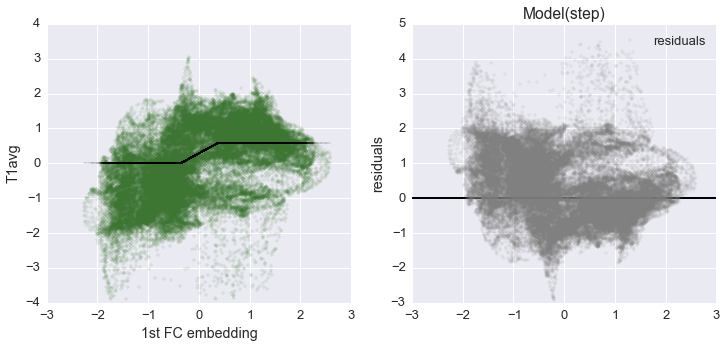

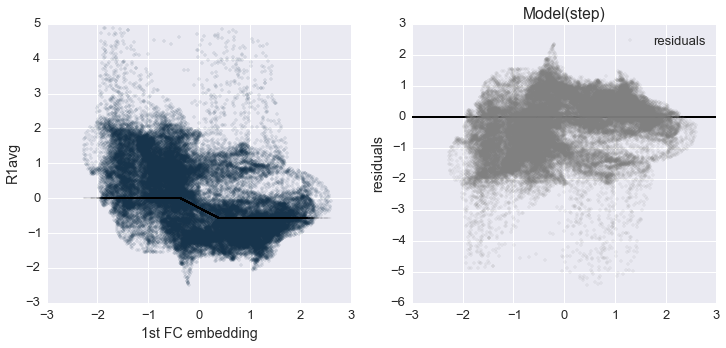

In [24]:
step_lin_mod = lmfit.models.StepModel(form='linear')

step_lin_t1 = fit_simple(step_lin_mod, 
                        x=embed1_t1_norm, y=t1_norm,
                        t1type='T1avg',
                        xlabel='1st FC embedding',
                        ylabel='T1avg', 
                        color=colors[3])


step_lin_r1 = fit_simple(step_lin_mod, 
                        x=embed1_r1_norm, y=r1_norm,
                        t1type='R1avg',
                        xlabel='1st FC embedding',
                        ylabel='R1avg', 
                        color=colors[1])

### Linear step function with constant

##### T1avg #####
[[Model]]
    (Model(step, form='linear') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 113
    # data points      = 58921
    # variables        = 4
    chi-square         = 39230.508
    reduced chi-square = 0.666
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.79280821 +/- 0.007058 (0.89%) (init=-3.892915)
    amplitude:         1.36587456 +/- 0.008763 (0.64%) (init= 6.952592)
    sigma:             0.99756043 +/- 0.017258 (1.73%) (init= 0.694249)
    center:           -0.83811292 +/- 0.009851 (1.18%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, center)             = -0.845 
    C(const_intercept, amplitude)  = -0.805 
    C(const_intercept, center)   =  0.523 
    C(amplitude, center)         = -0.422 
    C(amplitude, sigma)          =  0.371 
    C(const_intercept, sigma)    = -0.299 

BIC -23917.7603861
AIC -23953.6961975

##### R1avg #####
[[Model]]
    (Model(ste

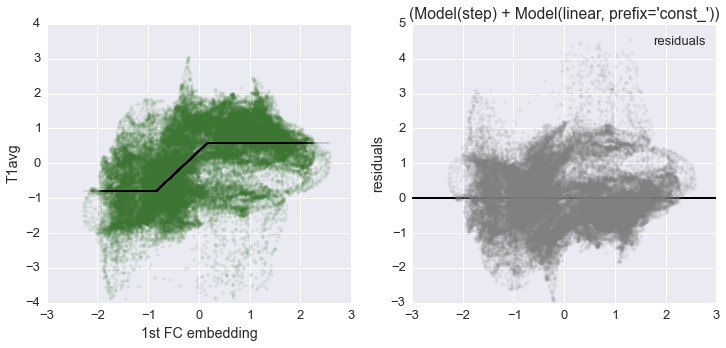

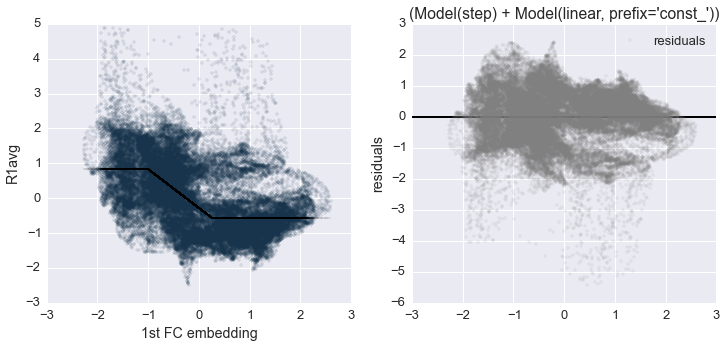

In [25]:
step_lin_const_t1 = fit_composite_const(step_lin_mod,
                                        x=embed1_t1_norm, y=t1_norm,
                                        t1type='T1avg',
                                        xlabel='1st FC embedding',
                                        ylabel='T1avg', 
                                        color=colors[3])

step_lin_const_r1 = fit_composite_const(step_lin_mod, 
                                        x=embed1_r1_norm, y=r1_norm,
                                        t1type='R1avg',
                                        xlabel='1st FC embedding',
                                        ylabel='R1avg', 
                                        color=colors[1])

### Arctan function + constant

##### T1avg #####
[[Model]]
    (Model(step, form='atan') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 58921
    # variables        = 4
    chi-square         = 39007.193
    reduced chi-square = 0.662
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.92491435 +/- 0.010956 (1.18%) (init=-3.892915)
    amplitude:         1.60548091 +/- 0.016482 (1.03%) (init= 6.952592)
    sigma:             0.24421185 +/- 0.009188 (3.76%) (init= 0.694249)
    center:           -0.34449932 +/- 0.005338 (1.55%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(const_intercept, amplitude)  = -0.918 
    C(amplitude, sigma)          =  0.818 
    C(const_intercept, sigma)    = -0.731 
    C(const_intercept, center)   =  0.417 
    C(amplitude, center)         = -0.184 

BIC -24254.1187307
AIC -24290.054542

##### R1avg #####
[[Model]]
    (Model(step, form='atan') + Model(linear, prefix='const_'

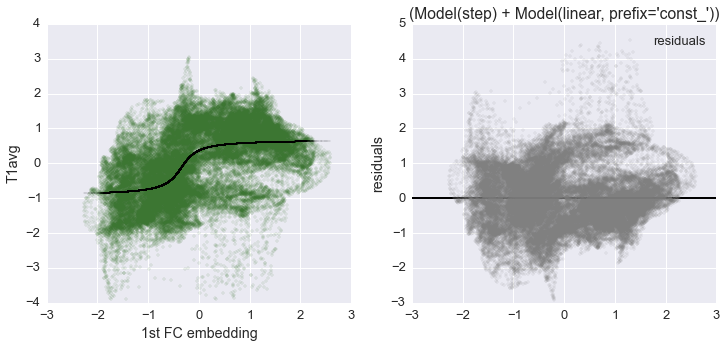

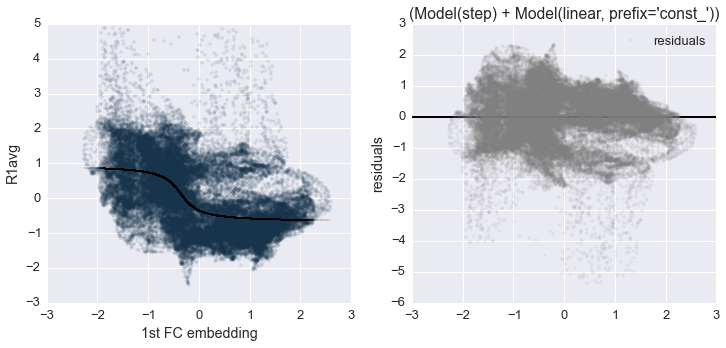

In [26]:
step_atan_mod = lmfit.models.StepModel(form='atan')

step_atan_const_t1 = fit_composite_const(step_atan_mod,
                                        x=embed1_t1_norm, y=t1_norm,
                                        t1type='T1avg',
                                        xlabel='1st FC embedding',
                                        ylabel='T1avg', 
                                        color=colors[3])

step_atan_const_r1 = fit_composite_const(step_atan_mod, 
                                        x=embed1_r1_norm, y=r1_norm,
                                        t1type='R1avg',
                                        xlabel='1st FC embedding',
                                        ylabel='R1avg', 
                                        color=colors[1])

### Logistic function + constant

##### T1avg #####
[[Model]]
    (Model(step, form='logistic') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 58921
    # variables        = 4
    chi-square         = 42338.589
    reduced chi-square = 0.719
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.51743863 +/- 0        (0.00%) (init=-3.892915)
    amplitude:         1.06133821 +/- 0        (0.00%) (init= 6.952592)
    sigma:             5.5096e-07 +/- 0        (0.00%) (init= 0.694249)
    center:           -0.12676883 +/- 0        (0.00%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)

BIC -19425.3738758
AIC -19461.3096872

##### R1avg #####
[[Model]]
    (Model(step, form='logistic') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 65
    # data points      = 58818
    # variables        = 4
    chi-square         = 39497.303
    reduced chi-square = 0.672
[[Variables]]
    const_slope:    

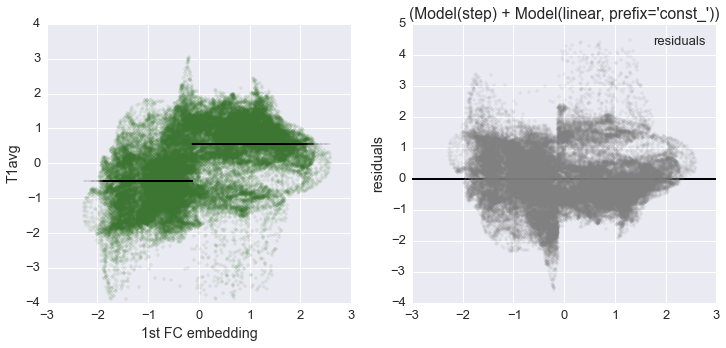

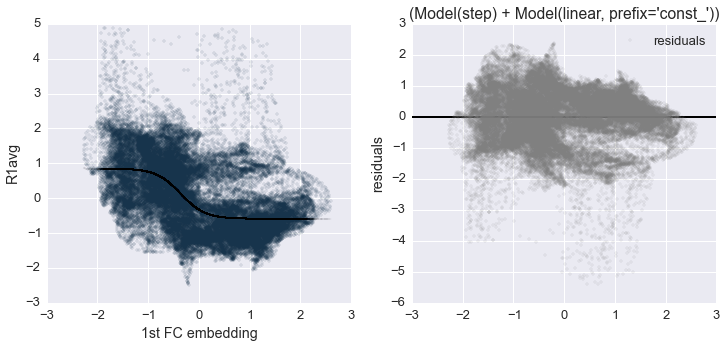

In [27]:
step_log_mod = lmfit.models.StepModel(form='logistic')

step_log_const_t1 = fit_composite_const(step_log_mod,
                                        x=embed1_t1_norm, y=t1_norm,
                                        t1type='T1avg',
                                        xlabel='1st FC embedding',
                                        ylabel='T1avg', 
                                        color=colors[3])

step_log_const_r1 = fit_composite_const(step_log_mod, 
                                        x=embed1_r1_norm, y=r1_norm,
                                        t1type='R1avg',
                                        xlabel='1st FC embedding',
                                        ylabel='R1avg', 
                                        color=colors[1])

### Error function + constant

##### T1avg #####
[[Model]]
    (Model(step, form='erf') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 58921
    # variables        = 4
    chi-square         = 39060.231
    reduced chi-square = 0.663
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.83197189 +/- 0.008577 (1.03%) (init=-3.892915)
    amplitude:         1.42260265 +/- 0.010649 (0.75%) (init= 6.952592)
    sigma:             0.53260883 +/- 0.012740 (2.39%) (init= 0.694249)
    center:           -0.34436974 +/- 0.006097 (1.77%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(const_intercept, amplitude)  = -0.855 
    C(amplitude, sigma)          =  0.599 
    C(const_intercept, center)   =  0.549 
    C(const_intercept, sigma)    = -0.525 
    C(amplitude, center)         = -0.261 

BIC -24174.0577794
AIC -24209.9935907

##### R1avg #####
[[Model]]
    (Model(step, form='erf') + Model(linear, prefix='const_')

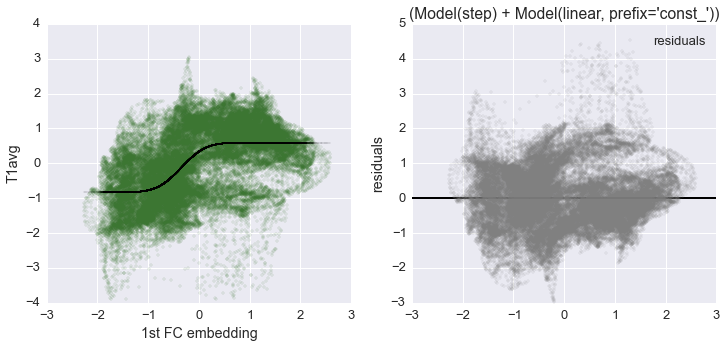

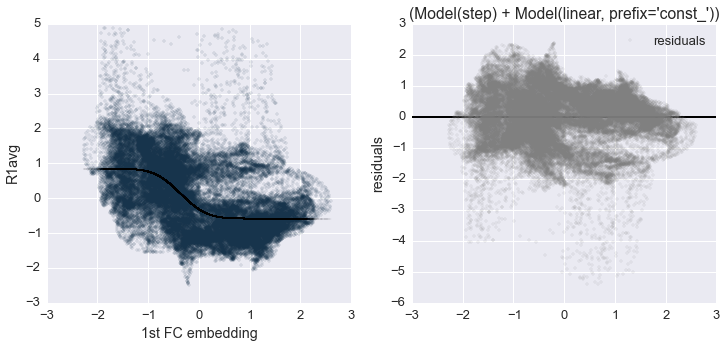

In [28]:
step_erf_mod = lmfit.models.StepModel(form='erf')

step_erf_const_t1 = fit_composite_const(step_erf_mod,
                                        x=embed1_t1_norm, y=t1_norm,
                                        t1type='T1avg',
                                        xlabel='1st FC embedding',
                                        ylabel='T1avg', 
                                        color=colors[3])

step_erf_const_r1 = fit_composite_const(step_erf_mod, 
                                        x=embed1_r1_norm, y=r1_norm,
                                        t1type='R1avg',
                                        xlabel='1st FC embedding',
                                        ylabel='R1avg', 
                                        color=colors[1])

### Compare different models

In [29]:
names = ['linear', 'quadratic', 'poly3', 'poly4', 'poly5', 'poly6', 'poly7', 
         'step lin', 'step atan', 'step log', 'step erf']

t1_results = [lin_t1, quad_t1, poly3_t1, poly4_t1, poly5_t1, poly6_t1, poly7_t1, 
                     step_lin_const_t1, step_atan_const_t1, step_log_const_t1, step_erf_const_t1]

r1_results = [lin_r1, quad_r1, poly3_r1, poly4_r1, poly5_r1, poly6_r1, poly7_r1, 
                     step_lin_const_r1, step_atan_const_r1, step_log_const_r1, step_erf_const_r1]

df = pd.DataFrame()

df['Value']=[m.bic for m in t1_results]+[m.aic for m in t1_results]+[m.bic for m in r1_results]+[m.aic for m in r1_results]
df['Model']=4*names
df['Criterion']=len(t1_results)*['BIC T1']+len(t1_results)*['AIC T1']+len(r1_results)*['BIC R1']+len(r1_results)*['AIC R1']


df2 = pd.DataFrame()

df2['Model'] = 2*names
df2['Datatype'] = len(names)*['T1']+len(names)*['R1']
df2['Chisqr'] = [m.chisqr for m in t1_results] + [m.chisqr for m in r1_results]
df2['Reduced Chi'] = [m.redchi for m in t1_results] + [m.redchi for m in r1_results]

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


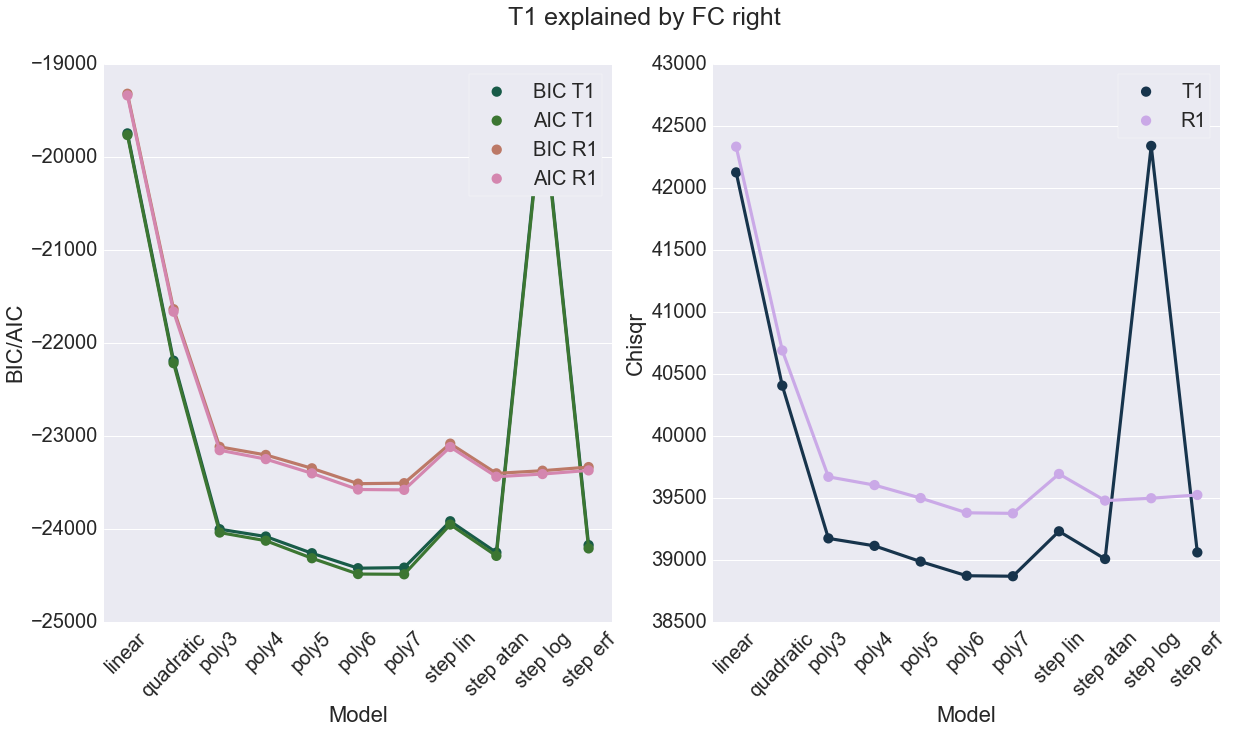

In [30]:
sns.set_context('notebook', font_scale=2)

fig=plt.figure(figsize=(20,10))
fig.add_subplot(121)
#sns.barplot(data=df, y='Model', x='Value', hue='Criterion', 
#            palette=[colors[2], colors[3], colors[5], colors[6]])
sns.pointplot(data=df, x='Model', y='Value', hue='Criterion', linestyles='-',
             palette=[colors[2], colors[3], colors[5], colors[6]])
plt.legend(loc=1, frameon=True)
plt.ylabel('BIC/AIC')
plt.xticks(rotation=45)

fig.add_subplot(122)
#sns.barplot(data=df2, y='Model', x='Reduced Chi', hue='Datatype', 
#            palette=[colors[3], colors[5]])
sns.pointplot(data=df2, x='Model', y='Chisqr', hue='Datatype', 
           palette=[colors[1], colors[7]])
plt.legend(loc=1, frameon=True)
plt.ylabel('Chisqr')
plt.xticks(rotation=45);

if hemi=='lh':
    hemistring='left'
elif hemi=='rh':
    hemistring='right'
else:
    hemistring='both'
plt.suptitle('T1 explained by FC %s'%hemistring, fontsize=25)

In [31]:
t1_df = pd.DataFrame()
t1_df['Model']=names
t1_df['T1 BIC']=[m.bic for m in t1_results]
t1_df['T1 AIC']=[m.bic for m in t1_results]
t1_df['T1 Chisqr']=[m.chisqr for m in t1_results]
t1_df

Model        T1 BIC        T1 AIC     T1 Chisqr
0      linear -19747.334311 -19747.334311  42125.002240
1   quadratic -22191.144801 -22191.144801  40405.341777
2       poly3 -24003.482965 -24003.482965  39173.473675
3       poly4 -24082.122089 -24082.122089  39113.269417
4       poly5 -24261.568288 -24261.568288  38986.399323
5       poly6 -24422.609609 -24422.609609  38872.081136
6       poly7 -24416.457636 -24416.457636  38868.233698
7    step lin -23917.760386 -23917.760386  39230.507587
8   step atan -24254.118731 -24254.118731  39007.193047
9    step log -19425.373876 -19425.373876  42338.588711
10   step erf -24174.057779 -24174.057779  39060.231448

In [32]:
r1_df = pd.DataFrame()
r1_df['Model']=names
r1_df['R1 BIC']=[m.bic for m in r1_results]
r1_df['R1 AIC']=[m.bic for m in r1_results]
r1_df['R1 Chisqr']=[m.chisqr for m in r1_results]
r1_df

Model        R1 BIC        R1 AIC     R1 Chisqr
0      linear -19321.001115 -19321.001115  42332.393633
1   quadratic -21637.672897 -21637.672897  40689.161708
2       poly3 -23117.844172 -23117.844172  39669.902037
3       poly4 -23204.770603 -23204.770603  39603.248943
4       poly5 -23348.576160 -23348.576160  39498.492887
5       poly6 -23513.684054 -23513.684054  39379.749019
6       poly7 -23508.517755 -23508.517755  39375.185823
7    step lin -23083.371964 -23083.371964  39693.158691
8   step atan -23402.914756 -23402.914756  39478.100860
9    step log -23374.312158 -23374.312158  39497.303329
10   step erf -23335.207397 -23335.207397  39523.571583